In [1]:
import matplotlib.pyplot as plt
import torch
import sympy
import numpy as np

# Automatic Differentiation

Automatic differentation (AD) is a method to compute accurate derivatives of computer programs. It is a widely applicable method used in optimization problems such as the training of neural networks via gradient descent.

Asside from machine learning applications, AD can be used in any context where we want to efficently and accurately compute the derivative of a suitable computer program.

As opposed to traditional approach for differentiation such as Finite Differences (FD), AD can evaluate the derivative of a function exactly and efficiently. Let's see an example:

## 1. Finite Differences

A "naive" approach to differentiation corresponds to computing

$$ \frac{\partial f}{\partial x} \approx  \frac{f(x+\epsilon) - f(x)}{\epsilon} $$

for a small value of $\epsilon$. Let's see how this performs:

In [2]:
def function(x):
    return x**3 + 4*x**2 - 10

def function_true_derivative(x):
    return 3*x**2 + 8*x

def get_fd_derivative(f, x, epsilon):
    return (f(x + epsilon) - f(x)) / (epsilon)

In [3]:
x = np.linspace(-5, 5, 10)
y = function(x)
epsilon = 1e-2
yp_true = function_true_derivative(x)
yp_fd = get_fd_derivative(function, x, epsilon)

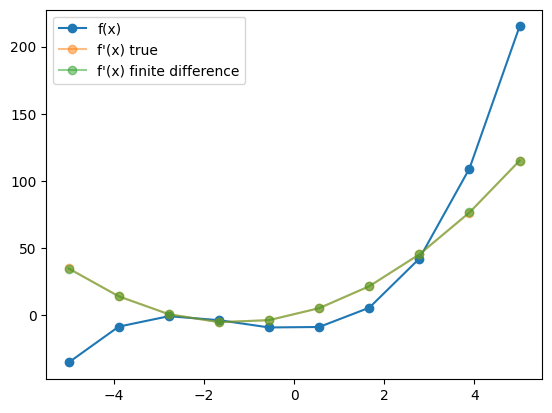

In [4]:
fig, ax = plt.subplots()
ax.plot(x, y, "o-", label='f(x)')
ax.plot(x, yp_true, "o-", label="f'(x) true", alpha=0.5)
ax.plot(x, yp_fd, "o-", label="f'(x) finite difference", alpha=0.5)
ax.legend()

Seems to work really well! Let's check another example.

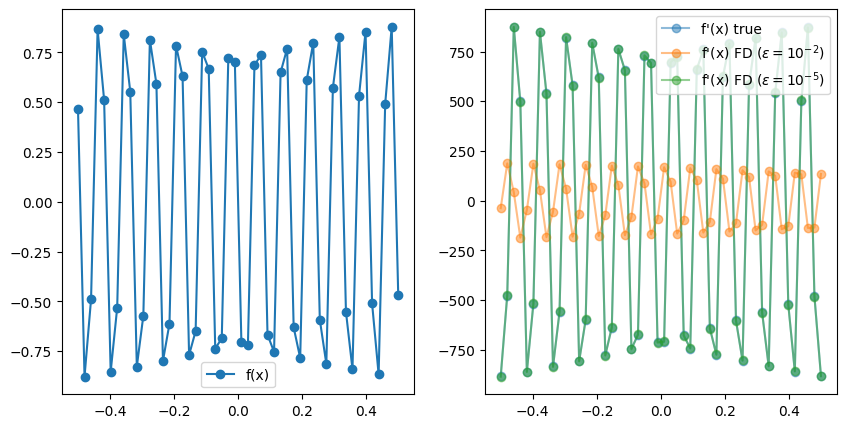

In [5]:
x = np.linspace(-0.5, 0.5, 50)
f = lambda x: np.sin(1000*x)
y = np.sin(1000*x)
yp_true = 1000 * np.cos(1000*x)
yp_fd_1 = get_fd_derivative(f, x, epsilon=1e-2)
yp_fd_2 = get_fd_derivative(f, x, epsilon=1e-5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, y, "o-", label='f(x)')
ax[0].legend()
ax[1].plot(x, yp_true, "o-", label="f'(x) true", alpha=0.5)
ax[1].plot(x, yp_fd_1, "o-", label=r"f'(x) FD ($\epsilon=10^{-2}$)", alpha=0.5)
ax[1].plot(x, yp_fd_2, "o-", label=r"f'(x) FD ($\epsilon=10^{-5}$)", alpha=0.5)
ax[1].legend()

In this case, FD failed to obtain an accurate result for $\epsilon=10^{-2}$ and we had to signficantly reduce it to match the analytical result. This is a common problem in FD where choosing the right value for $\epsilon$ may require experimentation and manual tunning. Furthermore, the FD method does not scale well with the number of input dimensions. That is, if $x \in \mathbb R^n$, then we require $n$ evaluations to obtain all the $\partial f / x_i$. If we imagine $f$ to be a neural network with potentially milions of parameters, this makes FD an unpractical choice.

## 2.  Symbolic differentiation

An alternative differentiation method to finite differences is Symbolic Differentiation (SD). This is the method implemented by software packages such as Mathematica, or the Python library sympy.
The basic idea is to hard-code the derivative of basic functions such as $\sin(x), \exp(x)$, etc. and composition rules such as

$$ (ab)' = a'b + ab' $$

and apply them recursively to obtain the exact derivative of a function. Let's see how this works:

In [6]:
x_sym = sympy.Symbol('x')
def f(x):
    return 3 * x**2 -x + 1
f_sym = f(x_sym)
f_sym

3*x**2 - x + 1

In [7]:
f_sym.diff(x_sym)

6*x - 1

This way, we are able to obtain the *exact* analytical expression for the derivative and we have no problems with oscillatory functions as before

In [8]:
x_sym = sympy.Symbol('x')
def f(x):
    return sympy.sin(1000*x)
f_sym = f(x_sym)
f_sym.diff(x_sym)

1000*cos(1000*x)



What's the catch then? Well, let's try a more complicated function:

In [9]:
def f_recursive(x):
    for i in range(4):
        x = f(x)
    return x
f_sym = f_recursive(x_sym)
f_sym

sin(1000*sin(1000*sin(1000*sin(1000*x))))

In [10]:
f_sym.diff(x_sym)

1000000000000*cos(1000*x)*cos(1000*sin(1000*x))*cos(1000*sin(1000*sin(1000*x)))*cos(1000*sin(1000*sin(1000*sin(1000*x))))

This looks pretty horrible! We have run across what is known as "expression swell". Naively expressing our full computer program as an analaytical expression may not be the best idea...

Just imagine a typical agent-based model with millions of agents and billions of operations! Obviously, the complete expression would not fit into memory and would be intractable to manage.

Furtheremore, symbolic differentiation is also incapable of handling control flow structures such as:

In [11]:
def f(x):
    if x < 2:
        return x**3
    if x >= 2:
        return 3* x

f(x_sym)

TypeError: cannot determine truth value of Relational

but this function is differentiable almost everywhere (except at $x=2$), so it is reasonable to expect to obtain a derivative outside of $x=2$.

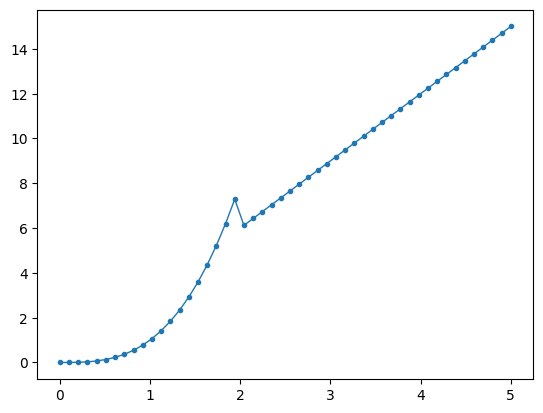

In [ ]:
x = np.linspace(0, 5, 50)
y = list(map(f, x))
plt.plot(x, y, "o-", markersize=3, lw=1)

## Expression representation

The problem with "expression swell" is due to us using a poor representation of the analytical expression. 

Consider the function:

In [ ]:
def f(x):
    x = x*x
    x = x*x
    x = x*x
    return x

We can represent this function as an expression tree [[1]](/https://arxiv.org/pdf/1904.02990.pdf):

<img src="../figures/expression_tree.png" height = 400 widht = 400/>



But actually, there is a significantly more efficient representation:

<img src="../figures/expression_dag.png" />

This representation form is known as the expression DAG, or computational graph, and is a much more efficient way to store the computational trace of a computer program. This type of representation solves the 'expresion swell' problem.

In reverse-mode AD packages such as PyTorch implement efficient ways of generating and storing the computational graph:

In [1]:
# !pip install torchviz

In [ ]:
import torchviz

def f(x, y):
    return x**2 + 4 * y + torch.cos(x)**2

x = torch.tensor(2.0, requires_grad=True) # PyTorch only tracks the graph involving variables that require grad.
y = torch.tensor(1.5, requires_grad=True)
z = f(x, y)

torchviz.make_dot(z, params={"x" : x, "y" : y}, show_attrs=True)


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Forward and Reverse mode automatic differentiation

Once we have stored the computation graph of the program, we can compute the derivative of it by applying the chain rule through each of the operations of the diagram.
This is equivalent to the way derivatives are obtained in the symbolic way, but the compact representation of the graph makes this problem way more tractable.

In the diagram above, PyTorch has a differentiation rule for each of the rectangles that represent a function (i.e, Cos, Mul, Pow), etc. and we can easily obtain the total derivative by propagating through the chain rule.

Note, however, that we have two equivalent ways of traversing the graph. We can start by the initial nodes $(x, y)$ and propagate the derivatives forward, or we can start by the final node $z$ and propagate them backwards.
The former is known as Forward-mode AD and the latter corresponds to reverse-mode AD. Both give identical results but they exhibit different performance depending on the situation.

Consider the two functions:

In [ ]:
def f1(x1):
    x1 = x1 * x1
    x1 = x1 * x1
    return [x1, x1, x1]

def f2(x1, x2, x3):
    x1 = x1 * x2 * x3
    x1 = x1 * x1
    return x1

The computational graphs of f1 and f2 are:


<p float="left">
  <img src="../figures/multiple_outputs.png" height = 300 width="200" />
  <img src="../figures/multiple_inputs.png" height = 300 width="200" /> 
</p>

Note that for f1, if we start from the bottom ($x_1$) and then chain the derivatives forward, we can reuse the intermediate computation between the 1st and the 3rd node.
If we start by the final nodes $(f_1, f_2, f_3)$ and work backwards, however, we need to traverse the graph 3 full times since we can't amortize any part of the computation.
The reverse is true for $f_2$.

This example illustrates the following result. Given a function 

$$f: \mathbb R^m \longrightarrow \mathbb R^n,$$

the computation of the jacobian

$$(J_f)_{ij} = \left(\frac{\partial f_i}{x_{j}}\right)$$

scales as $\mathcal O(m)$ for Forward-mode AD, and $\mathcal O(n)$ for reverse-mode AD.

In simpler words, we generally prefer to use forward-mode AD for functions with more inputs than outputs and viceversa. In machine learning, most training of neural networks requires the differentiation of the loss function, which is a function of many inputs (number of neural network parameters) and one output (e.g., result of L2 loss). For this reason, most AD packages focus such as PyTorch is on reverse-mode AD.

Let's run a few examples:




In [ ]:
from time import time

def make_f(n_outputs):
    def _f(x):
        return torch.sum(x) * torch.ones(n_outputs)
    return _f

# scale number of outputs
inputs = torch.ones(10)
results = {"outputs" : {"forward" : [], "reverse" : []}, "inputs" : {"forward" : [], "reverse" : []}}
f_inputs = make_f(10)
#n_range = [1, 10, 100, 1000, 10000]
n_range = np.arange(1, 10) * 1000
for n in n_range:
    f = make_f(n)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f, inputs, strategy="reverse-mode")
    t2 = time()
    results["outputs"]["reverse"].append(t2-t1)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f, inputs, strategy="forward-mode", vectorize=True)
    t2 = time()
    results["outputs"]["forward"].append(t2-t1)
    varying_inputs = torch.ones(n)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f_inputs, varying_inputs, strategy="reverse-mode")
    t2 = time()
    results["inputs"]["reverse"].append(t2-t1)
    t1 = time()
    jacobian = torch.autograd.functional.jacobian(f_inputs, varying_inputs, strategy="forward-mode", vectorize=True)
    t2 = time()
    results["inputs"]["forward"].append(t2-t1)

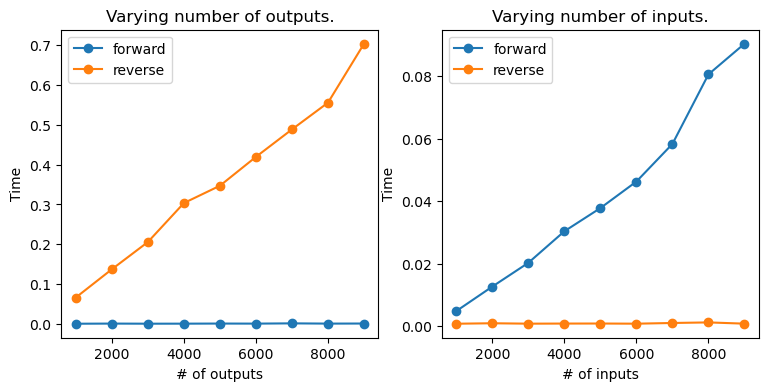

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title("Varying number of outputs.")
ax[0].plot(n_range, results["outputs"]["forward"], "o-", label = "forward")
ax[0].plot(n_range, results["outputs"]["reverse"], "o-", label = "reverse")
ax[0].set_xlabel("# of outputs")
ax[0].set_ylabel("Time")
ax[0].legend()

ax[1].set_title("Varying number of inputs.")
ax[1].plot(n_range, results["inputs"]["forward"], "o-", label = "forward")
ax[1].plot(n_range, results["inputs"]["reverse"], "o-", label = "reverse")
ax[1].set_xlabel("# of inputs")
ax[1].set_ylabel("Time")
ax[1].legend()
